# Twitter NLP Project

This project uses NLP to analyze tweets and better understand customer support interactions on Twitter.

While many consumers use traditional customer service avenues, like speaking to customer support over the phone, one-third of millennials use social media to connect with brands. And as more digital natives are born, that trend will likely continue and make social media-based customer service increasingly important. ([Steinmetz](https://time.com/4894182/twitter-company-complaints/))

This project's insights are valuable for:
* Companies that already use Twitter for customer support because they'll get a deeper understanding of their customer service interactions.
* And companies that want to start offering customer support on Twitter and need a strategy for that.


---


### Table of Contents

1. Importing the Dataset
2. Exploratory Data Analysis (EDA)
3. Topic Modeling
4. Classifying the Tweets
5. Sentiment Analysis
6. Text Generation
6. Key Takeaways
7. Next Steps
8. Resources
9. Appendix


---




### 1. Importing the Dataset

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/Colab Notebooks/Datasets for Data Science Projects/twcs.csv'
twitter_df = pd.read_csv(path)

### 3. Exploratory Data Analysis (EDA)

Because this is a new dataset, it'll be helpful to use EDA to get a feel for the data, add features, clean it up and explore it with visuals.

*The Dataframe*

In [4]:
twitter_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [5]:
twitter_df['author_id'].nunique()

702777

In [6]:
print(twitter_df['created_at'].min())
print(twitter_df['created_at'].max())

Fri Apr 01 17:37:48 +0000 2016
Wed Sep 28 18:06:15 +0000 2016


Intial observations: 

- The dataset's 2,811,774 rows by seven columns, which is large. 
- There are 702,777 unique authors in this dataset with an average of four tweets/author.
- The tweets are from the beginning of April through late September in 2016.
- Aside from the 'author_id', there's no information about the companies in the dataset. It'd be valuable to understand what kind of companies are in the dataset, so I'll add that information in the feature engineering section.

*Feature Engineering*

I'd like to add features related to the companies, like which industries they belong to, and will do that with in this section.

In [7]:
# I'll make a new dataframe to keep the changes separate from the original dataframe.
authors_df = twitter_df.copy()

# I'll also make a new variable, called 'numeric_author', and add it to the 'authors_df'. 
# This variable will show which values in the 'author_id' column are numeric. (Because individuals are represented by numbers, this will tell us which 'author_ids' are companies and which aren't.)
authors_df['numeric_author'] = authors_df['author_id'].str.isnumeric()
print(authors_df['numeric_author'])

0          False
1           True
2           True
3          False
4           True
           ...  
2811769    False
2811770     True
2811771     True
2811772    False
2811773     True
Name: numeric_author, Length: 2811774, dtype: bool


In [0]:
# I'll make another variable, called 'author_is_individual', to help me drop the individuals from the dataframe.
author_is_individual = authors_df[authors_df['numeric_author'] == True].index
authors_df.drop(author_is_individual, inplace=True)

In [9]:
# My sense is that the table only has companies listed, but I'll double-check that by looking at the values in that column.
# If all the values are false, that's a good sign.
authors_df['numeric_author'].unique()

array([False])

In [10]:
# Next, I'll get a list of the companies in the dataset.
authors_df['author_id'].unique()

array(['sprintcare', 'Ask_Spectrum', 'VerizonSupport', 'ChipotleTweets',
       'AskPlayStation', 'marksandspencer', 'MicrosoftHelps',
       'ATVIAssist', 'AdobeCare', 'AmazonHelp', 'XboxSupport',
       'AirbnbHelp', 'nationalrailenq', 'AirAsiaSupport', 'Morrisons',
       'NikeSupport', 'AskAmex', 'McDonalds', 'YahooCare', 'AskLyft',
       'UPSHelp', 'Delta', 'AppleSupport', 'Uber_Support', 'Tesco',
       'SpotifyCares', 'British_Airways', 'comcastcares', 'AmericanAir',
       'TMobileHelp', 'VirginTrains', 'SouthwestAir', 'AskeBay',
       'hulu_support', 'GWRHelp', 'sainsburys', 'AskPayPal', 'HPSupport',
       'ChaseSupport', 'CoxHelp', 'DropboxSupport', 'VirginAtlantic',
       'BofA_Help', 'AzureSupport', 'AlaskaAir', 'ArgosHelpers',
       'Postmates_Help', 'AskTarget', 'GoDaddyHelp', 'CenturyLinkHelp',
       'AskPapaJohns', 'SW_Help', 'askpanera', 'Walmart',
       'USCellularCares', 'AsurionCares', 'GloCare', 'idea_cares',
       'DoorDash_Help', 'NeweggService', 'VirginA

In [11]:
authors_df['author_id'].nunique()

108

Now that I know what companies are in the dataset, I'll add this business information:

1. Industry.
  - This will show which sector each company's in. This includes banks, retail, restaurants and so on.
  - To get the sector information, I went to the US Chamber of Commerce's [frequently asked questions page](https://www.uschamber.com/about/about-the-us-chamber/frequently-asked-questions#3) followed their guidance of using [Salesgenie](https://www.salesgenie.com/) to see how companies are classified. 
    * Note: Salesgenie only has information on US companies, but some of the companies in the dataset were from other countries or weren't listed on Salesgenie. In those cases, I assigned industries to companies based off how their American counter-parts had been classified. Or, if a company wasn't listed on Salesgenie, I assigned it to a a category that seemed like a good fit. For instance, I listed the Royal Bank of Canada as a bank and DoorDash as a restaurant.
    * For the full list of the companies that I assigned on my own, please see the Appendix.

2. NASDAQ Listing.
  - The NASDAQ information was gathered from [Yahoo! Finance](https://finance.yahoo.com/).

3. NASDAQ Price (in USD).
  - Where possible, I recorded each compnay's Adjusted Close Number on May 31, 2016. Then, for your reference, here's an example of a search where I took the [Adjusted Close Number for Adobe's stock from May 31, 2016](https://finance.yahoo.com/quote/ADBE/history?period1=1462078800&period2=1464757200&interval=1mo&filter=history&frequency=1mo).
  - Some companies that are listed on NASDAQ now, like Uber, weren't listed on the exchange in 2016 because they hadn't gone public yet. In some cases a company's not listed on NASDAQ because it's privately held. For those situations, I assigned the companies a value of zero to show that they're not listed.

4. Major Event.
  - If a company experienced an event that impacted thousands of people, like a service outtage, and the event was covered by multiple news sources I recorded that and assigned it a value of one; however, if a company didn't have a major event, it was given a zero.
  - For your reference, [here's an example of a search](https://www.google.com/search?biw=1920&bih=969&tbs=cdr%3A1%2Ccd_min%3A4%2F1%2F2016%2Ccd_max%3A9%2F28%2F2016&tbm=nws&ei=MznTXcm0Eoi8tgWlqqZY&q=london+midland&oq=london+midland&s_l=psy-ab.3..0l2.39991.41189.0.41514.14.11.0.3.3.0.165.1405.3j8.11.0....0...1c.1.64.psy-ab..1.13.1263...0i131k1.0.X-aRa17UL9k) with information about a train derailment that impacted London Midland's services. In the 'major_event' column, I said that a, "train derailment caused disruption in service".

5. Event Month.
  - Because the dataframe covers April 1st through September 28th, I looked for events that took place during that timeframe and noted the month as a number. (April was four, May was five and so on). 
  - If a company didn't have a major event, I put down a zero.

6. Event Highlights.
  - To provide insights, I wrote down a highlight about event.

7. Company.
  - To make it easier to tell companies and individuals apart, a column will be added to show if the author of a tweet is a company or an individual. 
  - If the author's a company, they'll get assigned a value of one. If it's an individual, the value will be zero.

Adding the new features to the dataframe:

In [0]:
# I'll make a new dataframe for the feature engineering.
feature_engineering_df = twitter_df.copy()

In [13]:
# Creating a column to show if the author of a tweet is a company or not.
list1 = []

for i in feature_engineering_df['author_id']:
 try:
   i = float(i)
 except:
   pass
 if type(i) in [int, float]:
   list1.append('non-company')
 else:
   list1.append(i)

feature_engineering_df['new_column'] = list1
print(feature_engineering_df)

         tweet_id   author_id  ...  in_response_to_tweet_id   new_column
0               1  sprintcare  ...                      3.0   sprintcare
1               2      115712  ...                      1.0  non-company
2               3      115712  ...                      4.0  non-company
3               4  sprintcare  ...                      5.0   sprintcare
4               5      115712  ...                      6.0  non-company
...           ...         ...  ...                      ...          ...
2811769   2987947  sprintcare  ...                2987948.0   sprintcare
2811770   2987948      823869  ...                      NaN  non-company
2811771   2812240      121673  ...                2812239.0  non-company
2811772   2987949      AldiUK  ...                2987950.0       AldiUK
2811773   2987950      823870  ...                      NaN  non-company

[2811774 rows x 8 columns]


In [0]:
# Droppping the 'author_id' column since 'new_column' has been added.
feature_engineering_df = feature_engineering_df[['tweet_id', 'inbound', 'created_at', 'text', 'response_tweet_id', 'in_response_to_tweet_id', 'new_column']]

In [0]:
# Renaming 'new_column' as 'author_id'.
feature_engineering_df = feature_engineering_df.rename(columns={'new_column': 'author_id'})

In [0]:
 # Creating a new column for 'company'.
feature_engineering_df['company'] = np.where(feature_engineering_df['author_id']=='non-company', 0, 1)

In [0]:
# To make it easy to maintain company information, I made a spreadsheet for the new columns.
path = '/content/drive/My Drive/Colab Notebooks/Industry List Spreadsheet - No Company Column.xlsx'
companies_df = pd.read_excel(path)

In [0]:
# Merging the 'feature_engineering_df' and 'companies_df' dataframes.
feature_engineering_df = feature_engineering_df.merge(companies_df, on='author_id', how='left')

In [19]:
feature_engineering_df.head()

,tweet_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,author_id,company,industry,nasdaq_listing,nasdaq_price,major_event,event_month,event_highlights
0,1,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,sprintcare,1,Cellular Telephones (Services),1.0,4.53,1.0,8.0,Sprint offers unlimited data plan.
1,2,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,non-company,0,non-company,0.0,0.00,0.0,0.0,NaN
2,3,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,non-company,0,non-company,0.0,0.00,0.0,0.0,NaN
3,4,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,sprintcare,1,Cellular Telephones (Services),1.0,4.53,1.0,8.0,Sprint offers unlimited data plan.
4,5,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,non-company,0,non-company,0.0,0.00,0.0,0.0,NaN


In [20]:
# Comparing the shape of the original and new dataframes to make sure nothing was lost.
print('- Shape of the Twitter dataframe:', twitter_df.shape)
print('- Shape of the feature engineering dataframe:', feature_engineering_df.shape)

- Shape of the Twitter dataframe: (2811774, 7)
- Shape of the feature engineering dataframe: (2811774, 14)


*Data Cleaning*

For the next step, the dataframe's text data needs to be cleaned.

In [0]:
# Making a new dataframe for the cleaning.
clean_df = feature_engineering_df.copy()

In [0]:
import re
import string

In [0]:
# First, the columns with text need to get converted from floats to strings.
def make_string(df, string):
  df[string] = df[string].astype(str)
  return;

In [0]:
make_string(clean_df, 'text')

In [0]:
make_string(clean_df, 'industry')

In [0]:
make_string(clean_df, 'event_highlights')

In [0]:
make_string(clean_df, 'created_at')

In [0]:
# The 'clean_text' function will: make text lowercase, remove text in the square brackets, remove punctuation and words that have numbers.
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\'\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    return text;

round1 = lambda x: clean_text(x)

In [0]:
clean_df['text'] = pd.DataFrame(clean_df['text'].apply(round1))

In [0]:
clean_df['industry'] = pd.DataFrame(clean_df['industry'].apply(round1))

In [0]:
clean_df['event_highlights'] = pd.DataFrame(clean_df['event_highlights'].apply(round1))

In [0]:
clean_df['created_at'] = pd.DataFrame(clean_df['created_at'].apply(round1))

*Visualizing the Data*

To get started, let's look the volume of Tweets sent by individuals and companies.

In [33]:
# Finding what percent of tweets were sent by individuals and companies.
clean_df['company'].value_counts('0.0')

0    0.54693
1    0.45307
Name: company, dtype: float64

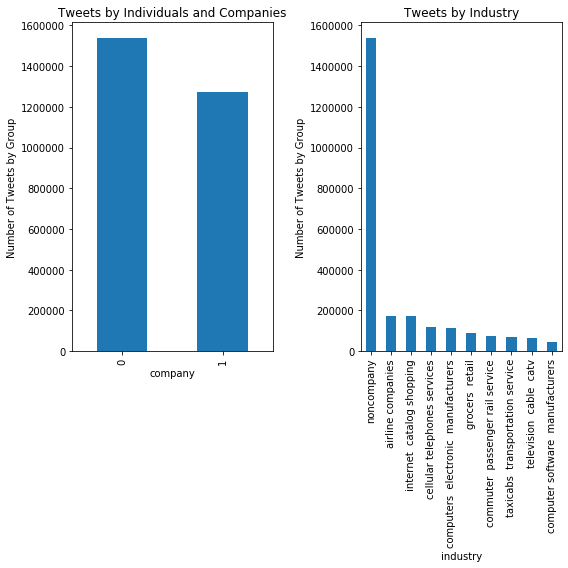

In [34]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
df = clean_df.groupby(['company'])['industry'].count()
plt.ylabel('Number of Tweets by Group')
plt.title('Tweets by Individuals and Companies')
df.plot.bar()

plt.subplot(1, 2, 2)

df = clean_df.groupby(['industry'])['company'].count().sort_values(ascending=False).iloc[:10]
plt.ylabel('Number of Tweets by Group')
plt.title('Tweets by Industry')
df.plot.bar()

plt.tight_layout()
plt.show()

Customers are sending quite a bit more tweets than companies are. Even with all of the companies' tweets combined, as a group customers sent 55% of the tweets while companies sent 45%.

Although, after consumers, airlines send the most tweets. That's likely because customers have learned that it's faster to get help from airlines on social media than it is to call customer service. ([Wolfe](https://www.nytimes.com/2018/11/20/travel/airline-customer-service-twitter.html))

In [0]:
# I need to make changes to the dataframe, so to make sure the 'clean_df' stays intact for future use, I'll make a new dataframe.
visual_df = clean_df.copy()
drop_non_company = visual_df[visual_df['company'] == 0].index
visual_df = visual_df.drop(drop_non_company)

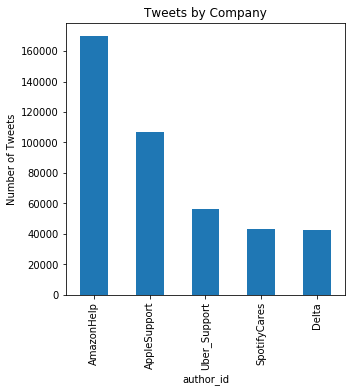

In [36]:
plt.figure(figsize=(5, 5))
df = visual_df.groupby(['author_id'])['company'].count().sort_values(ascending=False).iloc[:5]
plt.ylabel('Number of Tweets')
plt.title('Tweets by Company')

df.plot.bar()

By volume of Tweets, the top five companies are Amazon, Apple, Uber, Spotify and Delta. 

Given that (as a group) airline companies send the most tweets, it's suprising that there's only one airline company listed in the top five and that it's in fifth place. 

It's also interesting that four out of the top five companies rely heavily on technology to deliver their products and services. It's possible that because they're very comfortable with technology, it was easier for them to embrace Twitter when compared to other companies that are less tech-heavy.

In [37]:
visual_df['nasdaq_price'].describe()

count    1.272602e+06
mean     1.227558e+02
std      2.398390e+02
min      0.000000e+00
25%      0.000000e+00
50%      2.268000e+01
75%      9.037000e+01
max      7.156200e+02
Name: nasdaq_price, dtype: float64

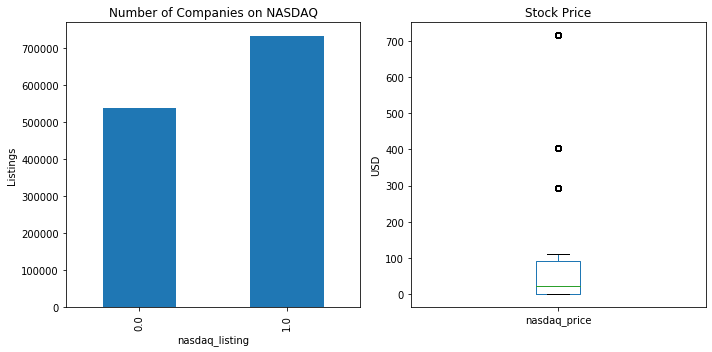

In [38]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df = visual_df.groupby(['nasdaq_listing'])['industry'].count()
plt.ylabel('Listings')
plt.title('Number of Companies on NASDAQ')
df.plot.bar()

plt.subplot(1, 2, 2)
df = visual_df['nasdaq_price']
plt.ylabel('USD')
plt.title('Stock Price')
df.plot.box()

plt.tight_layout()
plt.show()

Most of the companies that are sending tweets are listed on NASDAQ. This may be because Twitter's an easy way forfor businesses to have direct conversations with their customers, which could be especially important for large companies that have layers of bureaucracy. ([Parmar](https://hbr.org/2015/04/the-best-and-worst-corporate-tweeters))

Then, here are key figures (in USD) for the stock prices:
* Min. price: $0.

* Avg. price: $122.

* Max. price: $716.

The stock values suggests that providing customer support on Twitter is a value-add for a wide range of companies.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  app.launch_new_instance()


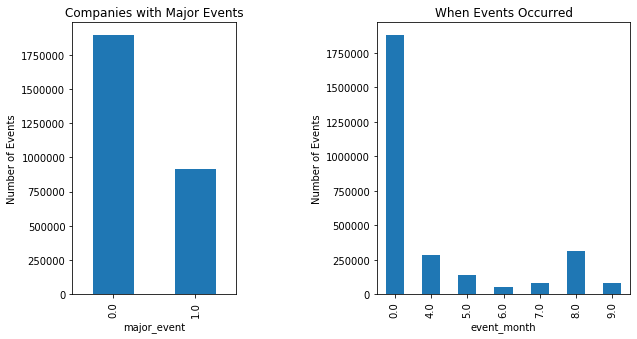

In [39]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
df = clean_df.groupby(['major_event'])['industry'].count()
plt.ylabel('Number of Events')
plt.title('Companies with Major Events')
df.plot.bar()

plt.subplot(1, 2, 2)

df = clean_df.groupby(['event_month'])['company'].count()
plt.ylabel('Number of Events')
plt.title('When Events Occurred')
df.plot.bar()

plt.tight_layout()
plt.show()

Most of the companies in the dataset didn't have a major event take place. Although for companies that went through an event, like a service disruption or new product release, events spiked in April and August.

If a company knows that a major event will likely happen (like a transportation company that typically has service disruptions due to winter storms), they can give special training to their customer service reps so that they can take advantage of the service recovery paradox and come out of the situation with stronger customer relationships. ([IGI Global](https://www.igi-global.com/dictionary/service-failure-and-recovery-strategy-in-computer-mediated-marketing-environments-cmmes/69930)) 

In [40]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')

from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def wordcloud(df, string):
  highlights = df[string].str.cat(sep=' ')

  tokens = word_tokenize(highlights)
  vocabulary = set(tokens)

  frequency_dist = nltk.FreqDist(tokens)

  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]

  wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()
  return;

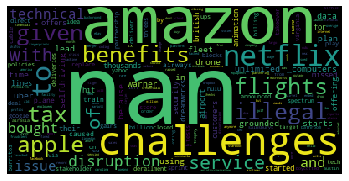

In [42]:
wordcloud(visual_df, 'event_highlights')

From a customer standpoint, the events which likely had the biggest impact on them were those related to service disruptions and new product offerings.
  * An example of this is the words "amazon," "netflix" and "challenges" are related to the headline, "Amazon challenges Netflix", which referred to Amazon changing its product offering and allowing customers to have month-to-month Prime Video memberships.

But other words in the wordcloud are related to business issues that may not directly impact customers.
  * This includes the words "illegal" and "apple", which are related to Apple getting sued for receiving illegal tax benefits. That was a major event, although it likely didn't have a major impact Apple's sales or customer relations.

What's valuable to note here is that even if a company experienced a major event, the importance of it should be looked at through the customers' eyes.

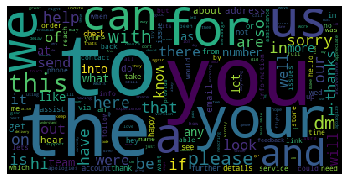

What companies are tweeting about compared to... None


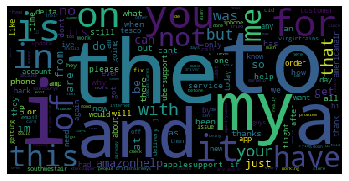

... what individuals are tweeting about: None


In [43]:
print('What companies are tweeting about compared to...', wordcloud(visual_df, 'text'))

visual_df = clean_df.copy()
drop_companies = visual_df[visual_df['company'] == 1].index
visual_df = visual_df.drop(drop_companies)
print('... what individuals are tweeting about:', wordcloud(visual_df, 'text'))

While there are stop words in the wordclouds above, there's an important detail in the wordcloud for companies: the businesses are frequently using the words "you" and "your". By doing that, they're keeping the focus on the customers and providing consistent interactions, which is important for customer satisfaction. ([Afshar](https://www.salesforce.com/blog/2019/06/customer-focus.html))

On the customer side, customers are focused on what's important to them, which shows up in "I" and "my."



---



### 4. Topic Modeling

To get started with the machine learning analysis, we'll use Latent Dirichlet Allocation (LDA) topic modeling to see what customers and companies are talking about.

In [44]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
stemmer = SnowballStemmer('english')

In [0]:
# This function will go through the pre-processing steps on the text data.
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize.
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result;

In [0]:
# Taking a random sample of the text data.
processed_docs = []

for doc in clean_df['text'].sample(n=50000, random_state=1):
    processed_docs.append(preprocess(doc))

In [0]:
# using gensim.corpora.Dictionary, I'll create a dictionary from 'processed_docs' that has the number of times a word appears in the training set.
dictionary = gensim.corpora.Dictionary(processed_docs)

In [49]:
# Checking the dictionary.
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 atviassist
1 applesupport
2 iphon
3 americanair
4 dont
5 dumb
6 know
7 store
8 think
9 pain
10 info


In [0]:
# Removing words that are used less than 15 times and that show up in more than 10% of all the documents.
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n=100000)

In [0]:
# Creating the BoW model for each document.
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [52]:
# Preview BoW for the sample preprocessed document.
document_num = 20
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 91 ("kind") appears 1 time.
Word 92 ("respons") appears 1 time.
Word 93 ("ubersupport") appears 1 time.


In [0]:
# The LDA model will be trained using gensim.models.LdaMulticore and saved to 'lda_model'.
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=6, workers=3)

In [54]:
# For each topic, we'll look at the words that occur and how much they weigh.
for idx, topic in lda_model.print_topics(-1, num_words=5):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    print('\n')

Topic: 0 
Words: 0.064*"amazonhelp" + 0.046*"order" + 0.027*"deliveri" + 0.022*"ubersupport" + 0.019*"amazon"


Topic: 1 
Words: 0.058*"issu" + 0.049*"work" + 0.029*"know" + 0.022*"let" + 0.019*"updat"


Topic: 2 
Words: 0.079*"servic" + 0.043*"custom" + 0.027*"time" + 0.025*"great" + 0.015*"hour"


Topic: 3 
Words: 0.054*"email" + 0.049*"account" + 0.045*"store" + 0.044*"address" + 0.043*"number"


Topic: 4 
Words: 0.026*"card" + 0.023*"virgintrain" + 0.020*"train" + 0.019*"ticket" + 0.017*"need"


Topic: 5 
Words: 0.055*"send" + 0.043*"sorri" + 0.039*"assist" + 0.032*"team" + 0.031*"hear"


Topic: 6 
Words: 0.048*"applesupport" + 0.034*"updat" + 0.025*"iphon" + 0.021*"phone" + 0.017*"happen"


Topic: 7 
Words: 0.032*"repli" + 0.029*"delta" + 0.019*"your" + 0.017*"hope" + 0.017*"welcom"


Topic: 8 
Words: 0.056*"flight" + 0.042*"delay" + 0.027*"sorri" + 0.025*"americanair" + 0.023*"check"


Topic: 9 
Words: 0.045*"like" + 0.023*"look" + 0.018*"idea" + 0.018*"chipotletweet" + 0.016*"se

*Notes on Tuning the Model Parameters*

I tried several different options while tuning the parameters and the current set of parameters gave the best results because each topic focused on a single subject and group of companies, like "AmericanAir" and "flight".

*Topic Analysis*

These topics had distinct themes:
- Topic 0 - Digital products.
- Topic 1 - Apple.
- Topic 2 - Gathering information to fix customer issues.
- Topic 3 - Amazon customer support.
- Topic 4 - Product delivery.
- Topic 5 - Amazon.
- Topic 6 - Acknowledging mistakes.
- Topic 7 - Flights.
- Topic 8 - Gathering information to fix customer issues.
- Topic 9 - Tesco.

Takeaways: 
- There's a mix of customers talking to companies about specific products and services, like having issues with travelling and needing product support.
- The topics that relate direclty to companies are a good example of the value-add topic modeling can bring to companies because it shows the words that are closely associated to them.

Next Steps:
- While it's helpful to see the language companies use when they need to fix a mistake, it could be worth adding words that showed up multiple times, like "account" to the stopwords list so that it's easier to find distinctive patterns.
- It may also be worth analyzing companies or industries by themselves to find patterns on a smaller scale.



---

### 5. Classifying the Tweets

For the purpose of using supervised learning techniques, I'll use machine learning to see if a tweet was from a company or an individual.

Note: in this case, classifying the information has limited value, but it is useful for other NLP projects, like spam filtering.

*Building the Train and Test Sets*


In [0]:
X_train = clean_df.loc[:24999, 'text'].values
y_train = clean_df.loc[:24999, 'company'].values
X_test = clean_df.loc[25000:, 'text'].values
y_test = clean_df.loc[25000:, 'company'].values

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [57]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
print(train_vectors.shape, test_vectors.shape)

(25000, 20432) (2786774, 20432)


*Running the Initial Models*

These models will be run:

1. Gradient Boosting.
2. Random Forest.
3. Naive-Bayes.
4. Linear Regression.

Please note that I ran SVM once, but it took two hours to process the information, so I removed it because of time constraints.

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.metrics import accuracy_score

In [0]:
# Defining a function to run a machine learning model and print out its accuracy score.
def classifier(model):
  predicted = model.fit(train_vectors, y_train).predict(test_vectors)
  print(accuracy_score(y_test, predicted))

In [60]:
# Gradient Boosting model.
classifier(ensemble.GradientBoostingClassifier())

0.8786083837440711


In [61]:
# Note: when I ran the random forest model the first time, I got a future warning about 'n_estimators'.
# To get rid of the warning, I set 'n_estimators=100'.
classifier(ensemble.RandomForestClassifier(n_estimators=100))

0.927606257270952


In [62]:
# Naive-Bayes model.
classifier(MultinomialNB())

0.9477460317915984


In [63]:
# Logistic Regression model.
# Note: when I ran the logistic regression model the first time, I got a future warning about 'solver'.
# To get rid of the warning, I set 'solver' equal to 'liblinear'.
classifier(LogisticRegression(solver='liblinear'))

0.949245974018704


*Running Models with Truncated SVD*

As an experiment, I'll see if the models perform better with truncated SVD.

(Please note that Naive-Bayes couldn't be run with SVD because it results in a ValueError message that says that "Input X must be non-negative.")

In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=5, random_state=42)

In [65]:
svd.fit(train_vectors)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=5, random_state=42,
             tol=0.0)

In [0]:
train_vectors = svd.transform(train_vectors)
test_vectors = svd.transform(test_vectors)

In [67]:
# Logistic Regression model.
classifier(LogisticRegression(solver='liblinear'))

0.8461457585006893


In [68]:
# Random Forest model.
classifier(ensemble.RandomForestClassifier(n_estimators=100))

0.8619809141322547


In [69]:
# Gradient Boosting model.
classifier(ensemble.GradientBoostingClassifier())

0.8617516167439484


*Insights*

* SVD negatively impacted the analysis and the models performed best on their own.
* Of the four models, Naive Bayes and logistic regression had the strongest performance.



---

### 6. Sentiment Analysis

By using TextBlob, we can measure sentiment objectively.

In [0]:
from textblob import TextBlob

In [0]:
sentiment_df = clean_df[['text', 'company', 'author_id', 'industry']].copy()

In [0]:
sentiment_df = sentiment_df.sample(n=40000, random_state=1)

In [0]:
def find_polarity(polarity):
    return TextBlob(polarity).sentiment.polarity

sentiment_df['polarity'] = sentiment_df['text'].apply(find_polarity)

In [0]:
def find_subjectivity(subjectivity):
    return TextBlob(subjectivity).sentiment.subjectivity;

sentiment_df['subjectivity'] = sentiment_df['text'].apply(find_subjectivity)

*Analyzing the Polarity*

The value of polarity can be between -1 and 1 where the reviews with negative polarities have negative sentiments, while the reviews with positive polarities have positive sentiments.

In [75]:
sentiment_df.groupby(['polarity']).first()

,text,company,author_id,industry,subjectivity
polarity,,,,,
-1.000000,wells fargo is the worst bank to have,0,non-company,noncompany,1.0000
-0.987500,very disappointed in americanair the service w...,0,non-company,noncompany,0.9875
-0.975000,thinking about especially very disappointed ...,0,non-company,noncompany,0.9750
-0.928571,pls fix my phone im very sick if i autocorrec...,0,non-company,noncompany,1.0000
-0.910000,i apologize again jessica as delivery will no...,1,UPSHelp,mailing shipping services,0.2600
...,...,...,...,...,...
0.866667,happy happy birthday to you we cant promise a...,1,AmericanAir,airline companies,1.0000
0.900000,i hear you amp i know that isnt an ideal situ...,1,TMobileHelp,cellular telephones services,1.0000
0.933333,wed do our best to match the joy given by tha...,1,ChipotleTweets,restaurant management,0.5000


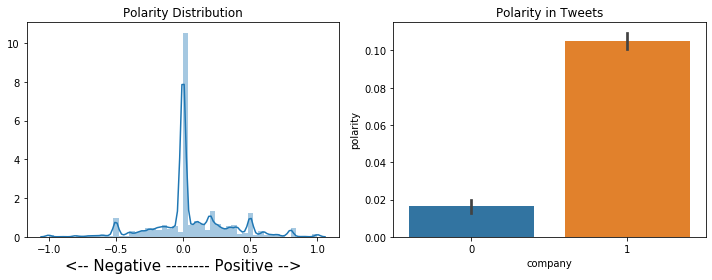

In [76]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.distplot(sentiment_df['polarity'])
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.title('Polarity Distribution')

plt.subplot(1, 2, 2)
sns.barplot(x='company', y='polarity', data=sentiment_df)
plt.title('Polarity in Tweets')

plt.tight_layout()
plt.show()

While the graphs show that customers' polarity is almost neutral, be mindful that consumers are likely coming to you when they have an issue that they need help with - if they're frustrated with an issue they're experiencing, they may vent their feelings in a tweet.

And on the whole, Twitter isn't known for neutrality. (Earlier this year Disney decided to not buy Twitter, citing the "nastiness" of Twitter's environment as the key reason why they didn't buy the company. [[Keown](https://www.barrons.com/articles/disney-snubbed-twitter-purchase-due-to-platforms-nastiness-ceo-bob-iger-reveals-51569248274?mod=article_signInButton?mod=article_signInButton)])

But if you're strategic and respond to your customers with empathy and thoughtfulness, they'll feel valued and your brand will get a boost. ([Parmar](https://hbr.org/2015/04/the-best-and-worst-corporate-tweeters))

*Analyzing Subjectivity*

The subjectivity value can be between 0 and 1. The value shows how much opinion or facts are in the text. A higher score means that the text is more opinionated than fact-based.

In [77]:
sentiment_df.groupby(['subjectivity']).first()

,text,company,author_id,industry,polarity
subjectivity,,,,,
0.000000,atviassist pls fix hqs,0,non-company,noncompany,0.000000
0.016667,hey we were off beat for a second but were ba...,1,SpotifyCares,radio stations broadcasting companies,-0.016667
0.022222,gwrhelp southampton to cardiff one ive been ...,0,non-company,noncompany,-0.022222
0.025000,gwrhelp just left a blue amp white golf umbrel...,0,non-company,noncompany,0.000000
0.033333,ideacares if issue is not resolved i will not ...,0,non-company,noncompany,0.000000
...,...,...,...,...,...
0.975000,im sorry about the unpleasant experience youv...,1,AmazonHelp,internet catalog shopping,-0.575000
0.975000,thinking about especially very disappointed ...,0,non-company,noncompany,-0.975000
0.983333,hi christina thank you for your feedback im p...,1,Tesco,grocers retail,0.616667


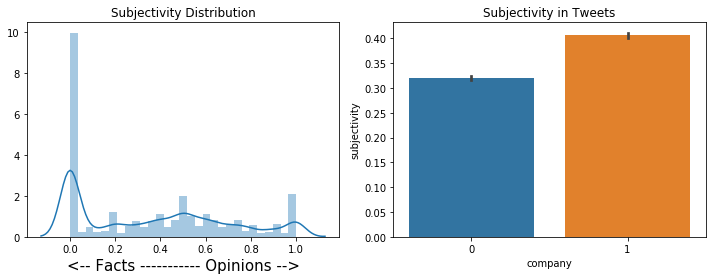

In [78]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.distplot(sentiment_df['subjectivity'])
plt.xlabel('<-- Facts ----------- Opinions -->', fontsize=15)
plt.title('Subjectivity Distribution')

plt.subplot(1, 2, 2)
sns.barplot(x='company', y='subjectivity', data=sentiment_df)
plt.title('Subjectivity in Tweets')

plt.tight_layout()
plt.show()

Interestingly, most of the information is fact-based, with companies being more factual than individuals.

For a company that wants to offer customer support via Twitter, focusing on sticking to the facts is a good strategy to keep in mind.

*Analzying Polarity and Subjectivity*

After looking at polarity and subjectivity as a whole, it'd be great to take a deeper look at how those values vary across some of the industries and companies.

In [0]:
# Setting up an 'industry_df'.
industry_df = sentiment_df[['industry', 'polarity', 'subjectivity']]
industry_df = industry_df.groupby(['industry']).mean().head(5)

In [0]:
# Setting up an 'author_df'.
author_df = sentiment_df[['author_id', 'polarity', 'subjectivity']]
author_df = author_df.groupby(['author_id']).mean().head(5)

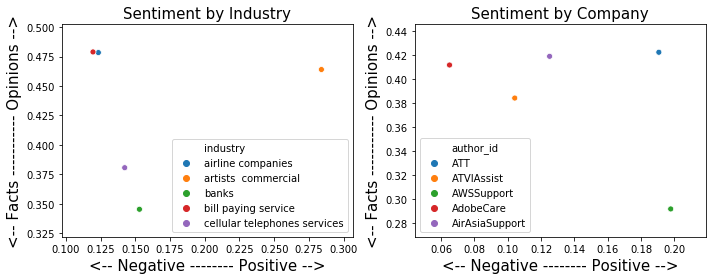

In [81]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(x=industry_df['polarity'], y=industry_df['subjectivity'], hue=industry_df.index, data=industry_df)
plt.title('Sentiment by Industry', fontsize=15)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts ----------- Opinions -->', fontsize=15)

plt.subplot(1, 2, 2)
sns.scatterplot(x=author_df['polarity'], y=author_df['subjectivity'], hue=author_df.index, data=author_df)
plt.title('Sentiment by Company', fontsize=15)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts ----------- Opinions -->', fontsize=15)

plt.tight_layout()
plt.show()

Across industries, there are big differences in how polarity and subjectivity is approached. And even within the industries, individual companies can break away from the group, which is shown by AirAsiaSupport and how its tweetes are more positive than that of the airline industry as a whole.

If a company's analyzing their tweets, they may want to see if they're aligned with the pack. It could make sense to stay there or they could be better off in taking their own approach. How they decide to handle that depends on what they value and how they want to be perceived. ([Cheng](https://www.forbes.com/sites/andriacheng/2018/10/08/wendys-twitter-roasts-have-become-the-envy-of-marketers-heres-how-it-does-it/#6b7919b6fea4))

Likewise, for a business that wants to offer customer support on Twitter, they could look at their industry as a whole to get a sense of how to approach tone.

### 6. Text Generation

For companies that want to offer customer support on Twitter, but who don't have the resources to write individual replies to every tweet they get, a text generator could be valuable.

In [82]:
pip install markovify

     |████████████████████████████████| 245kB 4.3MB/s 
  Created wheel for markovify: filename=markovify-0.8.0-cp36-none-any.whl size=10694 sha256=aa88481956be4e123d2b6a49e351e0ef585c1e3a1fc5c43487070fe7385a87d3
  Stored in directory: /root/.cache/pip/wheels/5d/a8/92/35e2df870ff15a65657679dca105d190ec3c854a9f75435e40
Successfully built markovify


In [0]:
import markovify

In [0]:
markovify_df = clean_df.copy()
drop = markovify_df[markovify_df['author_id'] != 'Delta'].index
markovify_df = markovify_df.drop(drop)

In [0]:
text_model = markovify.NewlineText(markovify_df['text'], state_size = 2)

In [86]:
# Print ten randomly-generated sentences using the built model
for i in range(10):
    print(text_model.make_sentence())

 it is never our goal is to go 
 my apologies regarding the flight canceled due to the reservation to see you again tjm
 it looks like youve already arrived our apology for the the charges you were assisted helping you if you would then conduct an internal social media team would be happy to assist you with this issue to maintenance ttn
 oh so cute thank you for reaching out to gogo wifi page and are taking it under serious advisement thank you for sharing aly
 is possible please be sure to speak with a reservation that you are more than one person can be for you ctb
 oh no i will definitely forward this concern with the confirmation number and ill see what i can see how i can check please provide your confirmation number id be happy to take a look please dm your confirmation number so i can assist with via twitter hca
 sorry for the delay we must do better if you havent received any notifications the den airport is still marking your reservations and make the reservation what is the d

The tweets that were generated aren't perfect, but they're a nice start. A business owner could use take this content, then update it so it's more polished and fits the conversation.

Added to that, this text generator is simple. If a more complex model was used, the text would be higher quality and a greater value-add.

---



### 7. Key Takeaways

With the models and analysis done, here's a recap of the value-add for: 

*Companies that Already Offer Customer Support on Twitter*
- Use LDA to figure out what's associated with your products and services. 
  * If the model shows you red flags, take that information to course correct.
- Objectively analyze the sentiment in your tweets and take a moment to decide if your tone matches with what you want to be known for. 
  * While it can seem like a small thing, getting your communication right can have big impacts for your business.

*Businesses that Want to Offer Customer Support on Twitter*
- Creating a communications strategy can be intimidating, so use data science to see what your peers are doing, then decide if you want to join the pack or stand out.
  * You'd take a risk by being individual, but if you create a voice that's unqiue and true to your brand that could translate to more profits. ([Cheng](https://www.forbes.com/sites/andriacheng/2018/10/08/wendys-twitter-roasts-have-become-the-envy-of-marketers-heres-how-it-does-it/#8c1ed1efea4c), [Vincent](https://www.fool.com/investing/2019/11/12/3-key-takeaways-from-wendys-q3-earnings.aspx))
- Use text generation to help you get started. 
  * Even though the text generation wasn't perfect, it'll help you avoid pitfalls (like the perfection trap) and get more comfortable with writing content.



---


### 8. Next Steps

*Analytical Changes*

In a future version of this project, here are changes that could be made: 

- First, it'd be great to see if there's a correlation between:
  * A major event and how many tweets a company gets, as well as if certain events draw more tweets than others (like a service disruption vs. an announcement about business strategy changes). 
  * How many tweets a company gets and the time of year.

- Then, it'd be interesting to look at inbound vs. outbound tweets and see if the interactions start negatively and end positively or if there's another, less obvious trend.

That additional analysis would lead to valuable insights that could help companies anticipate things like how many staff they'll need during certain times of the year and if they should change their guidance on how they direct customer service reps to handle conversations.

*Technical Changes*

- Remove non-English languages and emojis.
  * Non-English words and emojis didn't have a major impact on the models' results, though it'd be good to remove them from the dataset.


---


### 9. Resources

Below is a list of resources that was used for this project. For ease of use, the resources are grouped by Business Intelligence, the Kaggle Dataset and Technical Resources.

*Business Intelligence*

1. [Afshar](https://www.salesforce.com/blog/2019/06/customer-focus.html). Salesforce. "How to Improve Your Company’s Customer Focus."
2.  [Cheng](https://www.forbes.com/sites/andriacheng/2018/10/08/wendys-twitter-roasts-have-become-the-envy-of-marketers-heres-how-it-does-it/#28ef096dfea4). Forbes. "How Wendy's Learned To Stop Worrying And Love Its Twitter Roasts Of McDonald's."
3. [Google News](https://news.google.com/?hl=en-US&gl=US&ceid=US:en).
4. [IGI Global](https://www.igi-global.com/dictionary/service-failure-and-recovery-strategy-in-computer-mediated-marketing-environments-cmmes/69930)
5. [Keown](https://www.barrons.com/articles/disney-snubbed-twitter-purchase-due-to-platforms-nastiness-ceo-bob-iger-reveals-51569248274?mod=article_signInButton?mod=article_signInButton). Barron's. "Disney Pulled Out of Twitter Purchase Due to Platform’s ‘Nastiness,’ CEO Bob Iger Reveals."
6. [Parmar](https://hbr.org/2015/04/the-best-and-worst-corporate-tweeters). Harvard Business Review. "50 Companies That Get Twitter – and 50 That Don’t."
7. [Salesgenie.com](https://www.salesgenie.com/).
8. [Steinmetz](https://time.com/4894182/twitter-company-complaints/). Time - Tech. "Does Tweeting at Companies Really Work?"
9. [US Chamber of Commerce](https://www.uschamber.com/about/about-the-us-chamber/frequently-asked-questions#3). "Frequently Asked Questions."
10. [Vincent](https://www.fool.com/investing/2019/11/12/3-key-takeaways-from-wendys-q3-earnings.aspx). Motley Fool. "3 Key Takeaways from Wendy's Q3 Earnings."
11. [Wolfe](https://www.nytimes.com/2018/11/20/travel/airline-customer-service-twitter.html). New York Times. "Want Faster Airline Customer Service? Try Tweeting."
12. [Yahoo! Finance](https://finance.yahoo.com/).

*The Kaggle Datset*
1. [Kaggle - Customer Support on Twitter Dataset](https://www.kaggle.com/thoughtvector/customer-support-on-twitter/data).

*Technical Resources*
1. [Dwivedi](https://github.com/priya-dwivedi/Deep-Learning/blob/master/topic_modeling/LDA_Newsgroup.ipynb). GitHub. "Latent Dirichlet Allocation."
2. [Dwivedi](https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925). Towards Data Science. "NLP: Extracting the Main Topics From Your Dataset Using LDA in Minutes."
3. [Geeks for Geeks](https://www.geeksforgeeks.org/generating-word-cloud-python/). "Generating Word Cloud in Python."
4. [Majed Raja](https://datascienceplus.com/natural-language-generation-with-markovify-in-python/). Data Science+. "Natural Language Generation with Markovify in Python."
5. [Malik](https://stackabuse.com/python-for-nlp-introduction-to-the-textblob-library/). Stack Abuse. "Python for NLP: Introduction to the TextBlob Library."
6. [Nabi](https://towardsdatascience.com/machine-learning-text-processing-1d5a2d638958). Towards Data Science. "Machine Learning - Text Processing."
7. [Powell](http://setosa.io/ev/markov-chains/). Setosa. "Markov Chains Explained Visually."
8. [TextBlob](https://textblob.readthedocs.io/en/dev/advanced_usage.html#sentiment-analyzers). TextBlob. "Advanced Usage: Overriding Models and the Blobber Class."
9. [Zhao](https://github.com/adashofdata/nlp-in-python-tutorial). GitHub. "Natural Language Processing in Python Tutorial."




---


### 9. Appendix

For your reference, here's the list of non-US companies that were in the dataframe, along with companies that weren't categorized by Salesgenie, and which industry they were assigned to:

1. Aldi UK, Grocers - Retail.
2. Airtel Care, Telecommunications Services.
3. Argos, Retail.
4. British Airways, Airline Companies.
5. Dollar Shave Club, Retail.
6. DoorDash, Restaurants.
7. Glo, Cellular Telephones (Services).
8. Great Western Railway, Commuter & Passenger Rail Service.
9. Greggs, Restaurants.
10. Idea Cares, Cellular Telephones (Services).
11. InterContinental Hotel Group, Hotel & Motel Management.
12. London Midland, Commuter & Passenger Rail Service.
13. Marks and Spencer, Grocers - Retail.
14. Morrisons, Grocers - Retail.
15. MTNC, Cellular Telephones (Services).
16. National Rail, Commuter & Passenger Rail Service.
17. OPPO Care India, Cellular Telephones (Services).
18. Pearson, Education.
19. PlayStation, Video Games - Manufacturer.
20. Postmates, Restaurants.
21. Royal Bank of Canada, Banks.
22. Sainsburys, Grocers - Retail.
23. Size?, Retail.
24. SoundCloud, Radio Stations & Broadcasting Companies.
25. Spotify, Radio Stations & Broadcasting Companies.
26. Tesco, Grocers - Retail.
27. Tigo Ghana, Cellular Telephones (Services).
28. Transport for London, Commuter & Passenger Rail Service.
29. Virgin America, Airline Companies.
30. Virgin Atlantic, Airline Companies.
31. Virgin Mobile USA, Cellular Telephones (Services).
32. Virgin Money, Banks.
33. Virgin Trains, Commuter & Passenger Rail Service.